# Two-way ANOVA

A two-way ANOVA (Analysis of Variance) is a **parametric test** used to examine the effects of **two independent categorical factors** on a continuous dependent variable, including the possibility of an **interaction effect** between them.
It answers the question: *Do the factors, individually or in combination, have a statistically significant effect on the dependent variable?*

Common scenarios include:
* Evaluating production yields from multiple factories under different temperature settings.
* Comparing customer satisfaction scores among service providers across different regions.
* Investigating differences in average height across countries and genders. (SHOWN BELOW)

## Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy.random as rnd
from random import sample
import statsmodels.api as sm
import scipy.stats as stats
import pingouin as pg
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
rng = np.random.default_rng(42)

The dataset contains height measurements for 90 individuals from three countries (Country A, Country B, Country C), each with two gender groups.


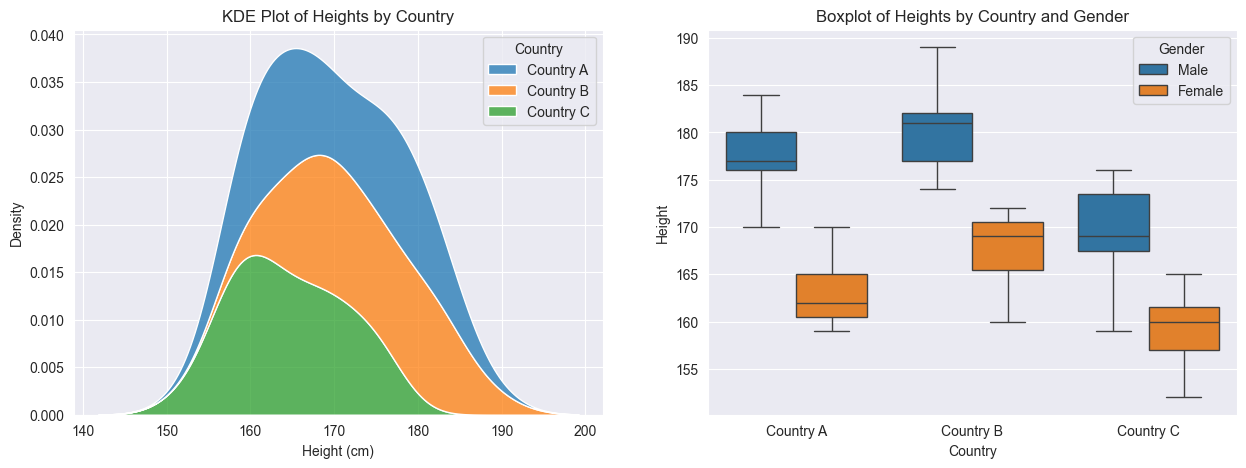

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

# Sample size per group (per gender in each country)
N = 15

# Simulate heights (mean and std chosen to create differences)
np.random.seed(42)  # For reproducibility
data = {
    "Country": [],
    "Gender": [],
    "Height": []
}

countries = ["Country A", "Country B", "Country C"]
genders = ["Male", "Female"]

# Simulate data
for country in countries:
    for gender in genders:
        if country == "Country A":
            mean_height = 178 if gender == "Male" else 165
        elif country == "Country B":
            mean_height = 182 if gender == "Male" else 168
        elif country == "Country C":
            mean_height = 170 if gender == "Male" else 160
        heights = np.random.normal(mean_height, 4, N).astype(int)
        data["Country"].extend([country] * N)
        data["Gender"].extend([gender] * N)
        data["Height"].extend(heights)

df = pd.DataFrame(data)

# Overview of dataset
print(f"The dataset contains height measurements for {len(df)} individuals "
      f"from three countries ({', '.join(countries)}), each with two gender groups.")

display(HTML(
    f"""
    <div style="display: flex; gap: 50px;">
        <div>{df.head().to_html()}</div>
        <div>{df.describe().T.to_html()}</div>
    </div>
    """
))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# KDE plot by Country and Gender
sns.kdeplot(ax=axes[0], data=df, x="Height", hue="Country", multiple="stack", fill=True)
axes[0].set_title("KDE Plot of Heights by Country")
axes[0].set_xlabel("Height (cm)")

# Boxplot by Country and Gender
sns.boxplot(ax=axes[1], data=df, x="Country", y="Height", hue="Gender")
axes[1].set_title("Boxplot of Heights by Country and Gender")

plt.show()


### Hypothesis

$H_0$: There is no difference in mean height between countries, between genders, or due to the interaction of country and gender.  
$H_a$: At least one factor (country, gender, or their interaction) has a significant effect on mean height.

**Assumptions**
* **Assumption 1:** The dependent variable is continuous (height measured in centimeters).
* **Assumption 2:** Observations are independent — each individual’s height measurement is unrelated to any other’s.
* **Assumption 3:** The data contains no extreme outliers (could disproportionately influence the mean).
* **Assumption 4:** The height values in each combination of country and gender are approximately normally distributed.
* **Assumption 5:** The variability of heights is roughly equal across all country–gender groups (homogeneity of variances).


#### Assumption 1
This assumption is valid because height is measured on a ratio scale in centimeters (cm), which is a continuous variable with equal intervals and a true zero.


#### Assumption 2  
This assumption is valid because:  
**Independence between groups:** Each participant’s height was recorded for only one combination of country and gender, with no individual appearing in more than one group.  
**Independence within groups:** Each participant’s height measurement is independent of the measurements from other participants in the same country–gender group.  


#### Assumption 3
This assumption is valid because no outliers were found. If any had been found, they should be investigated to ensure they are not data entry errors, and, if valid, the entire dataset could be transformed to reduce their influence on the test or the analysis could switch to a nonparametric alternative.

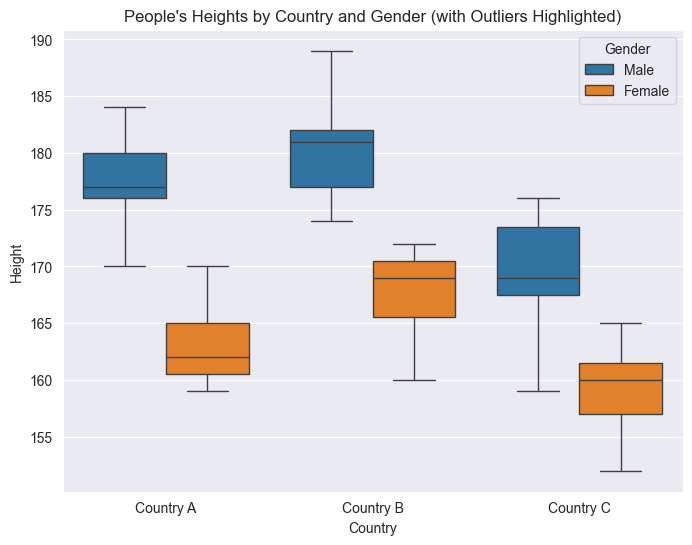

In [5]:
# Boxplot by Country and Gender
plt.figure(figsize=(8,6))
palette = ["#3D75A6", "#A63D3D", "#3DA66E"]  # Colors for countries
sns.boxplot(
    data=df,
    x="Country",
    y="Height",
    hue="Gender",
    flierprops={"markerfacecolor": "red", "marker": "o", "markersize": 6}
)

# Custom legend (countries + gender labels handled automatically by hue)
plt.title("People's Heights by Country and Gender (with Outliers Highlighted)")
plt.ylabel("Height")
plt.xlabel("Country")
plt.legend(title="Gender", loc="upper right")
plt.show()

#### Assumption 4
This assumption is valid because it passed both a visual check using a QQ plot against normal (Gaussian) quantiles and a formal Shapiro–Wilk test.

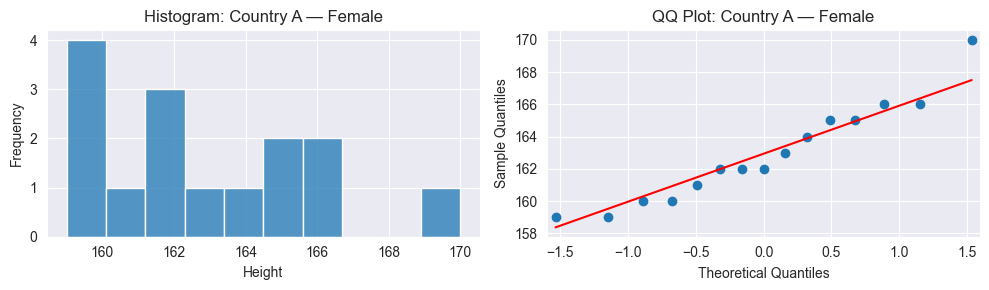

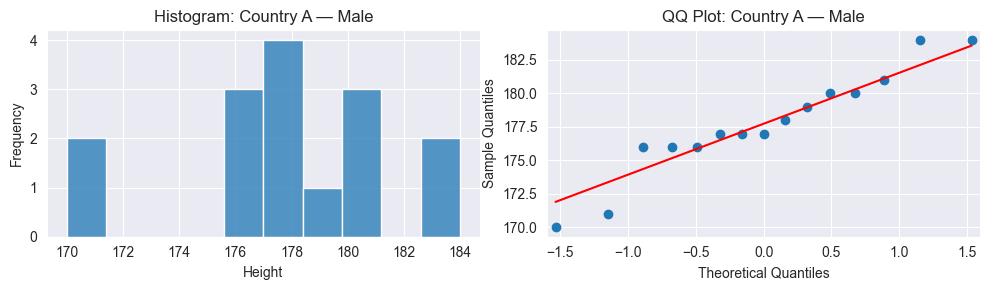

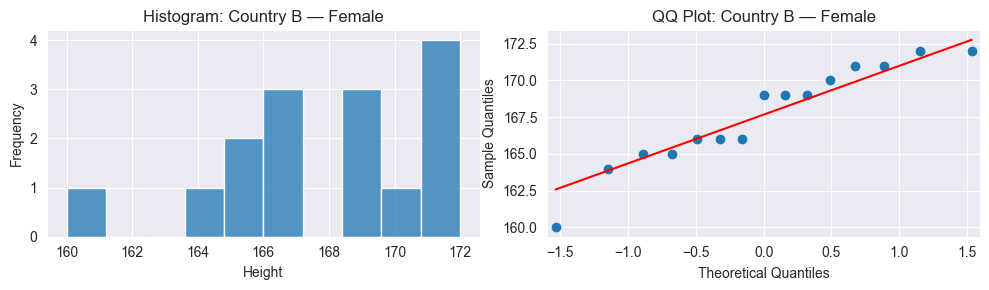

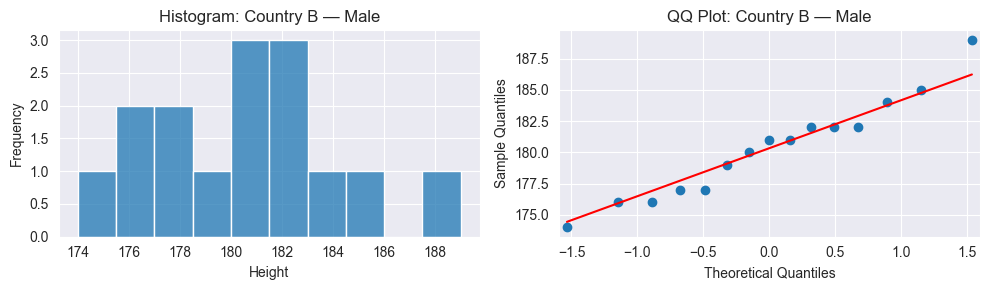

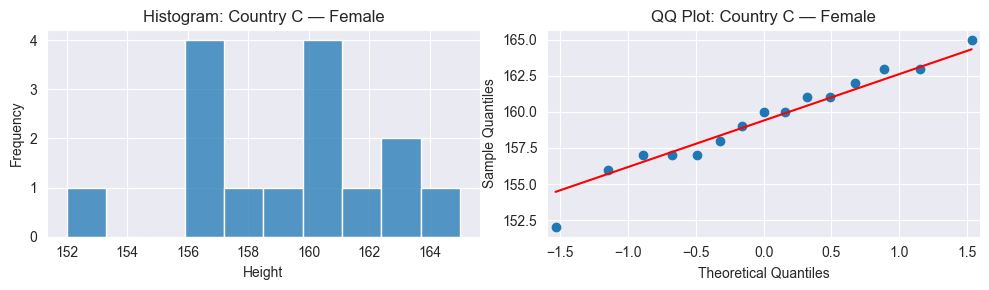

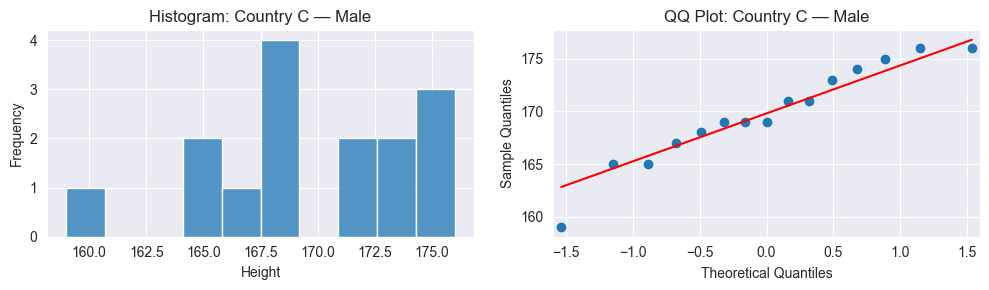

In [7]:
# For each Country × Gender group: Histogram and QQ plot
for (country, gender), grp in df.groupby(["Country", "Gender"]):
    heights = grp["Height"].values

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Histogram
    sns.histplot(heights, bins=10, ax=axes[0])
    axes[0].set_xlabel("Height")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"Histogram: {country} — {gender}")

    # QQ plot
    sm.qqplot(heights, dist=stats.norm, line='s', ax=axes[1])
    axes[1].set_title(f"QQ Plot: {country} — {gender}")

    plt.tight_layout()
    plt.show()


A QQ plot (Quantile–Quantile plot) is a **visual** way to check whether your data follows a certain theoretical distribution, in this case, the normal distribution.<br> The red line represents where the points would fall if the data’s distribution matched the theoretical distribution perfectly.

In [9]:
# Shapiro–Wilk test for each Country × Gender group
for (country, gender), grp in df.groupby(["Country", "Gender"]):
    heights = grp["Height"]
    shapiro_stat, shapiro_p = stats.shapiro(heights)
    print(f"{country} ({gender}) - Shapiro–Wilk Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}")

Country A (Female) - Shapiro–Wilk Test: W=0.940, p=0.377
Country A (Male) - Shapiro–Wilk Test: W=0.939, p=0.366
Country B (Female) - Shapiro–Wilk Test: W=0.928, p=0.252
Country B (Male) - Shapiro–Wilk Test: W=0.966, p=0.789
Country C (Female) - Shapiro–Wilk Test: W=0.971, p=0.878
Country C (Male) - Shapiro–Wilk Test: W=0.946, p=0.471


SHAPIRO–WILK test<br>
$p > 0.05 \; \Rightarrow$ Fail to reject normality (assumption is plausible).  
$p < 0.05 \; \Rightarrow$ Evidence of non-normality; consider transformations or a nonparametric test.

Therefore, we **fail to reject normality** for all groups (i.e. data is most likely normal).


#### Assumption 5

This assumption is valid because it passed a Bartlett’s test, indicating no statistically significant difference in variances across the three groups.

In [13]:
# Bartlett's test for homogeneity of variances across all Country–Gender groups
group_data = [grp["Height"].values for _, grp in df.groupby(["Country", "Gender"])]

stat_bartlett, p_bartlett = stats.bartlett(*group_data)
print(f"Bartlett’s test: stat={stat_bartlett:.4f}, p={p_bartlett:.4f}")


Bartlett’s test: stat=3.2738, p=0.6579


## Two-way ANOVA

In [15]:
pg.anova(dv='Height', between=['Country', 'Gender'], data=df, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Country,1346.755556,2,673.377778,47.037144,1.970058e-14,0.528287
1,Gender,3584.711111,1,3584.711111,250.401153,6.311450e-27,0.748805
2,Country * Gender,72.622222,2,36.311111,2.536423,8.519736e-02,0.056952
3,Residual,1202.533333,84,14.315873,NaN,NaN,NaN


#### P-values

**Country:**  
If the null hypothesis is true (mean height is the same across all countries), the probability of obtaining an $F$-statistic as extreme as the observed $(F(2,84) \approx 47.04)$ purely by chance is approximately $(p \approx 1.97 \times 10^{-14})$.  
Since this is far below 0.05, **we reject the null hypothesis** and conclude that at least one country’s mean height differs from the others.

**Gender:**  
If the null hypothesis is true (mean height is the same for males and females), the probability of obtaining an $F$-statistic as extreme as the observed $(F(1,84) \approx 250.40)$ purely by chance is approximately $(p \approx 6.31 \times 10^{-27})$.  
This is also far below 0.05, so **we reject the null hypothesis** and conclude that mean height differs significantly between genders.

**(Country × Gender):**  
If the null hypothesis is true (the effect of country on height does not depend on gender), the probability of obtaining an $F$-statistic as extreme as the observed $(F(2,84) \approx 2.54)$ purely by chance is approximately $(p \approx 0.085)$.  
Since this p-value is above 0.05, **we fail to reject the null hypothesis**, indicating no statistically significant interaction between country and gender in their effect on height.


#### F-statistic

The F statistic in a two-way ANOVA is the **ratio between the variance explained by an effect** (Factor A, Factor B, or their interaction) and the **variance within the groups**:<br>
Larger $F \Rightarrow$ the observed mean difference for that effect is large relative to the variation within groups.<br>
Smaller $F \Rightarrow$ the observed mean difference for that effect is small compared to the variation, suggesting more similarity.

$$
F_{\text{effect}} \;=\; \frac{MS_{\text{effect}}}{MS_{\text{within}}}
\;=\; \frac{\frac{SS_{\text{effect}}}{df_{\text{effect}}}}{\frac{SS_{\text{within}}}{df_{\text{within}}}}
$$

Where:

- **$SS_{\text{effect}}$** measures the variability explained by:
  - **Factor A (Country)**: differences between country means, ignoring gender.
  - **Factor B (Gender)**: differences between gender means, ignoring country.
  - **Interaction (Country × Gender)**: how much the effect of country on height changes depending on gender.
- **$df_{\text{effect}}$** depends on the effect being tested:  
  - Factor A: $a - 1$  
  - Factor B: $b - 1$  
  - Interaction: $(a - 1)(b - 1)$  
  where $a$ = number of levels of Factor A, $b$ = number of levels of Factor B.
- **$SS_{\text{within}}$** measures the variability of the data points from their respective group means (each unique combination of factors).
- **$df_{\text{within}} = N - (a \times b)$** where $N$ is the total number of observations.

**Interpretation:**  
The numerator represents the variation explained by the effect of interest, and the denominator represents the unexplained variation within groups.  
- For **Factor A**, a large $F$ means country has a strong influence on height regardless of gender.  
- For **Factor B**, a large $F$ means gender has a strong influence on height regardless of country.  
- For the **interaction**, a large $F$ means the effect of country on height depends on gender (or vice versa). A small $F$ means the pattern of differences between countries is similar for both genders.


<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
    <figure style="display: flex; flex-direction: column; align-items: center; margin: 0;">
        <figcaption><strong>Variance between groups (SSB=SSEffect)</strong></figcaption>
        <img src="../Images/SSB.png" width="300" height="200">
    </figure>
    <figure style="display: flex; flex-direction: column; align-items: center; margin: 0;">
        <figcaption><strong>Variance within groups (SSW)</strong></figcaption>
        <img src="../Images/SSW.png" width="300" height="200">
    </figure>
</div>


#### Partial Eta Squared ($\eta_p^2$)

Partial eta squared is a **measure of effect size** used in ANOVA that represents the proportion of variance in the dependent variable (heights) that is **attributable to a specific effect** — this could be a main effect (e.g., Country, Gender) or the interaction between factors (Country × Gender).  

In a **two-way ANOVA**, partial eta squared is calculated separately for each effect. For the interaction term, it reflects the proportion of variance in height explained by the combined influence of Country and Gender, after controlling for the main effects of each factor.

It answers: *What proportion of the variability in height can be explained by the interaction between Country and Gender?*

$$
\eta_p^2 = \frac{SS_{\text{effect}}}{SS_{\text{effect}} + SS_{\text{within}}}
$$

Where:
- $SS_{\text{effect}}$ = Sum of squares for the effect of interest (e.g., Country, Gender, or Country × Gender)  
- $SS_{\text{within}}$ = Sum of squares for the error (within-group variation)  

**Interpretation guidelines** (Cohen, 1988):  
- Small effect: $\eta_p^2 \approx 0.01$  
- Medium effect: $\eta_p^2 \approx 0.06$  
- Large effect: $\eta_p^2 \approx 0.14$  


### Manual Calculation of Two-Way ANOVA

N = 90, a = 3 levels of Country, b = 2 levels of Gender
Grand mean = 169.644

Sums of Squares and DF
SS_A   = 1346.756, df_A   = 2
SS_B   = 3584.711, df_B   = 1
SS_A×B = 72.622, df_A×B = 2
SS_within = 1202.533, df_within = 84
SS_total  = 6206.622,  df_total  = 89

Mean Squares, F, p
 Country: MS=673.378,   F(2,84)  = 47.037,  p = 1.97e-14,  partial η² = 0.528
  Gender: MS=3584.711,   F(1,84)  = 250.401,  p = 6.311e-27,  partial η² = 0.749
     A×B: MS=36.311, F(2,84) = 2.536,  p = 0.0852,  partial η² = 0.057


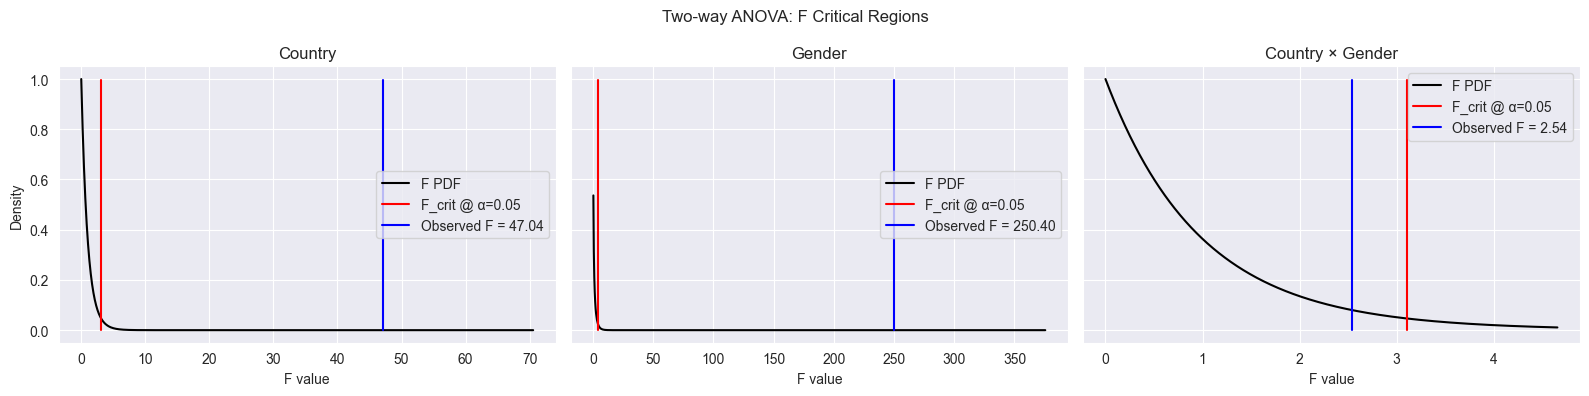

In [19]:
import numpy as np
import pandas as pd
from scipy import stats

# Expect df to have columns: "Country", "Gender", "Height (cm)"
# If your column is named differently (e.g., "Height"), change dv below.
dv = "Height"
A = "Country"
B = "Gender"

# --- Helper aggregates ---
grand_mean = df[dv].mean()
N = df.shape[0]

# cell summaries (for each Country × Gender)
cell = df.groupby([A, B])[dv].agg(['count', 'mean'])
cell = cell.rename(columns={'count': 'n', 'mean': 'cell_mean'}).reset_index()

# marginal by A and B
A_marg = df.groupby(A)[dv].agg(['count', 'mean']).rename(columns={'count':'nA', 'mean':'meanA'}).reset_index()
B_marg = df.groupby(B)[dv].agg(['count', 'mean']).rename(columns={'count':'nB', 'mean':'meanB'}).reset_index()

# merge marginals back to cell table for easy vectorized formulas
cell = cell.merge(A_marg, on=A).merge(B_marg, on=B)

# --- Sums of Squares ---
# Total SS
SS_total = ((df[dv] - grand_mean) ** 2).sum()

# Within (Error): sum over cells of sum_i (x - cell_mean)^2
# Compute by merging cell means onto original df
df_tmp = df.merge(cell[[A, B, 'cell_mean']], on=[A, B], how='left')
SS_within = ((df_tmp[dv] - df_tmp['cell_mean']) ** 2).sum()

# Between (Model): deviation of cell means from grand mean, weighted by cell n
SS_between = (cell['n'] * (cell['cell_mean'] - grand_mean) ** 2).sum()

# Main effects via marginal means (handles unbalanced designs)
# SSA: sum_a n_a.(X_a. - grand)^2
SS_A = (A_marg['nA'] * (A_marg['meanA'] - grand_mean) ** 2).sum()

# SSB: sum_b n_.b(X_.b - grand)^2
SS_B = (B_marg['nB'] * (B_marg['meanB'] - grand_mean) ** 2).sum()

# Interaction: whatever is left in between after removing main effects
SS_AB = SS_between - SS_A - SS_B

# --- Degrees of freedom ---
a = A_marg.shape[0]
b = B_marg.shape[0]

df_A  = a - 1
df_B  = b - 1
df_AB = (a - 1) * (b - 1)
df_within = N - (a * b)
df_total  = N - 1

# --- Mean Squares ---
MS_A  = SS_A  / df_A
MS_B  = SS_B  / df_B
MS_AB = SS_AB / df_AB
MS_within = SS_within / df_within

# --- F statistics & p-values (upper tail) ---
F_A  = MS_A  / MS_within
F_B  = MS_B  / MS_within
F_AB = MS_AB / MS_within

p_A  = stats.f.sf(F_A,  df_A,  df_within)
p_B  = stats.f.sf(F_B,  df_B,  df_within)
p_AB = stats.f.sf(F_AB, df_AB, df_within)

# --- Optional effect sizes: partial eta squared ---
eta2p_A  = SS_A  / (SS_A  + SS_within)
eta2p_B  = SS_B  / (SS_B  + SS_within)
eta2p_AB = SS_AB / (SS_AB + SS_within)

# --- Print a compact summary ---
print(f"N = {N}, a = {a} levels of {A}, b = {b} levels of {B}")
print(f"Grand mean = {grand_mean:.3f}")
print()
print("Sums of Squares and DF")
print(f"SS_A   = {SS_A:.3f}, df_A   = {df_A}")
print(f"SS_B   = {SS_B:.3f}, df_B   = {df_B}")
print(f"SS_A×B = {SS_AB:.3f}, df_A×B = {df_AB}")
print(f"SS_within = {SS_within:.3f}, df_within = {df_within}")
print(f"SS_total  = {SS_total:.3f},  df_total  = {df_total}")
print()
print("Mean Squares, F, p")
print(f"{A:>8}: MS={MS_A:.3f},   F({df_A},{df_within})  = {F_A:.3f},  p = {p_A:.4g},  partial η² = {eta2p_A:.3f}")
print(f"{B:>8}: MS={MS_B:.3f},   F({df_B},{df_within})  = {F_B:.3f},  p = {p_B:.4g},  partial η² = {eta2p_B:.3f}")
print(f"{'A×B':>8}: MS={MS_AB:.3f}, F({df_AB},{df_within}) = {F_AB:.3f},  p = {p_AB:.4g},  partial η² = {eta2p_AB:.3f}")

def plot_three_F(Fs, dfs1, df2, labels, alpha=0.05, suptitle="Two-way ANOVA: F Critical Regions"):
    fig, axes = plt.subplots(1, 3, figsize=(16,4), sharey=True)
    for ax, F_obs, df1, lab in zip(axes, Fs, dfs1, labels):
        F_crit = stats.f.ppf(1 - alpha, df1, df2)
        x_max = max(F_crit, F_obs) * 1.5
        xs = np.linspace(0, max(3, x_max), 1000)
        ax.plot(xs, stats.f.pdf(xs, df1, df2), 'k', label="F PDF")
        ax.axvline(F_crit, ymin=0.045, ymax=0.95, color='red', label=f'F_crit @ α={alpha:.2f}')
        ax.axvline(F_obs,  ymin=0.045, ymax=0.95, color='blue', label=f'Observed F = {F_obs:.2f}')
        ax.set_title(lab)
        ax.set_xlabel("F value")
        if ax is axes[0]:
            ax.set_ylabel("Density")
        ax.legend()
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

plot_three_F(
    Fs=[F_A, F_B, F_AB],
    dfs1=[df_A, df_B, df_AB],
    df2=df_within,
    labels=["Country", "Gender", "Country × Gender"],
    alpha=0.05
)

## Conclusion

A two-way ANOVA was conducted to examine the effects of **Country**, **Gender**, and their interaction on participants’ heights. Assumptions of continuity, independence of observations, approximate normality within groups, and homogeneity of variances were considered to be met.  

Results showed a **statistically significant main effect** of Country on height, $F(2, 84) = 47.04$, $p < 0.001$, with a partial $\eta^2 = 0.528$, indicating that approximately **52.8\%** of the variance in height is explained by differences between countries — a **large** effect.  

There was also a **statistically significant main effect** of Gender, $F(1, 84) = 250.40$, $p < 0.001$, with a partial $\eta^2 = 0.749$, suggesting that approximately **74.9\%** of the variance in height is explained by gender differences — an **extremely large** effect.  

The Country × Gender interaction was **not statistically significant**, $F(2, 84) = 2.54$, $p = 0.085$, partial $\eta^2 = 0.057$, indicating that the effect of country on height does not depend meaningfully on gender.  

**These results provide strong evidence that both country and gender independently influence height, with gender explaining the largest proportion of variance, and no meaningful interaction between the two factors.**


REFERENCE: https://www.youtube.com/watch?v=YllG5Cy6OFw&ab_channel=StatswithBrian